#### Optimize the data for both 1yr, 10yr surveys for ugrizy. 
    - Restrict attention to only those areas where there's data for all-6 bands. 
    - Within all-band footprint, implement depth masking (no border masking at all), i.e,. mask/discard all pixels with depth<magcut in i-band, and restrict to stats in those pixels for all six bands.

##### For 1yr data, the median depths are renormalized to match the depth achieved with 10% WFD visits since 1yr (=first 365 nights) in minion1016 doesn't contain 10% of total visits.

#### Final result: last output which prints out the stats with the finalized depth cuts.

For skymaps, for a few cuts (vs. without depth cuts), see Output19.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import healpy as hp
from collections import OrderedDict
import pandas as pd
from IPython.display import display
from copy import deepcopy
from scipy.stats import iqr
from os.path import expanduser
home = expanduser("~")

Read in the data

In [2]:
dir_paths= {}
dir_paths['1yr']= '/lsstData/DepthData_1yr/coaddM5Analysis_nside256_withDustExtinction_minion1016_1yrCut_directory/'
dir_paths['10yr']= '/lsstData/DepthData_10yr/coaddM5Analysis_nside256_withDustExtinction_minion1016_fullSurveyPeriod_directory/'

filenames= {}
filenames['1yr'] = [f for f in os.listdir(home+dir_paths['1yr']) if any([f.endswith('.npz') and not f.startswith('._')])]
filenames['10yr'] = [f for f in os.listdir(home+dir_paths['10yr']) if any([f.endswith('.npz') and not f.startswith('._') and not f.__contains__('_masked_')])]

In [3]:
filenames

{'10yr': ['coaddM5Data_unmasked_g_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_i_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_r_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_u_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_y_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_z_RepulsiveRandomDitherFieldPerVisit.npz'],
 '1yr': ['coaddM5Data_unmasked_g_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_i_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_r_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_u_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_y_RepulsiveRandomDitherFieldPerVisit.npz',
  'coaddM5Data_unmasked_z_RepulsiveRandomDitherFieldPerVisit.npz']}

Set up data as a masked array; analyze things without MAF.

In [4]:
orderBand= ['i', 'u', 'g', 'r', 'z', 'y']
data= OrderedDict()
for case in filenames.keys():
    for ith in range(len(filenames[case])): #[::-1]:
        filename= [f for f in filenames[case][::-1] if f.__contains__('_%s_'%orderBand[ith])][0]
        os.chdir(home+dir_paths[case])
        key= filename.split('_Rep')[0].split('unmasked_')[1]
        data[case + '_' + key]= np.load(filename)

In [5]:
import numpy.ma as ma
dataMaps= OrderedDict()
for key in data.keys():
    dataMaps[key]= data[key]['metricValues'].view(ma.MaskedArray)
    dataMaps[key].mask= data[key]['mask']
    dataMaps[key].fill_value= data[key]['fill']

In [6]:
# check the improvement factor between 1, 10yr data
allImprovs= []
for band in orderBand:
    key= '1yr_%s'%band
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positive= np.where(dataMaps[key].data > 0)[0]
    common= list(set(positive).intersection(inSurveyIndex))
    oneYrMed= np.median(dataMaps[key].data[common])
    
    key= '10yr_%s'%band
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positive= np.where(dataMaps[key].data > 0)[0]
    common= list(set(positive).intersection(inSurveyIndex))
    tenYrMed= np.median(dataMaps[key].data[common])
    
    oneYrFlux= 10**(-oneYrMed/2.5)
    tenYrFlux= 10**(-tenYrMed/2.5)
    print('%s-band: improv factor in flux: %s'%(band, oneYrFlux/tenYrFlux))
    allImprovs.append(oneYrFlux/tenYrFlux)
print('\nWanted improv factor: ', np.sqrt(10.))
print('Mean improv factor across ugrizy: ', np.mean(allImprovs))

i-band: improv factor in flux: 4.92785605402
u-band: improv factor in flux: 4.93776636103
g-band: improv factor in flux: 4.94884473088
r-band: improv factor in flux: 5.2234517317
z-band: improv factor in flux: 3.57235416898
y-band: improv factor in flux: 3.46934136326

Wanted improv factor:  3.16227766017
Mean improv factor across ugrizy:  4.51326906831


##### The improvement from 1-10yr is too good -- 1yr in minion1016 strongly prefers DDFs so 1yr defined by the number of the nights doesnt have 10% of total visits (has <7%). For now, renormalize the 1yr depth s.t. median matches that after 10% of 10-year WFD observations.

In [7]:
wanted1yr_medianDepth= {'g': 25.377165833786055,
 'i': 24.910057884620223,
 'r': 25.565945074516804,
 'u': 23.795160853950424,
 'y': 23.315667199085482,
 'z': 24.002597276614527}

In [8]:
for key in dataMaps.keys():
    if key.__contains__('1yr'):
        band= key.split('1yr_')[1]
        print(band)
        inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
        medDepth= np.median(dataMaps[key].data[inSurveyIndex])
        print('Median depth as read: ', np.median(dataMaps[key].data[inSurveyIndex]))
        delm= wanted1yr_medianDepth[band]-medDepth
        print('m_wanted-m_current = ', delm)
        dataMaps[key].data[:]+=delm
        print('Renormalized map. \nNew median: ', np.median(dataMaps[key].data[inSurveyIndex]))
        print('')

i
Median depth as read:  24.5616715751
m_wanted-m_current =  0.348386309501
Renormalized map. 
New median:  24.9100578846

u
Median depth as read:  23.4579727053
m_wanted-m_current =  0.337188148632
Renormalized map. 
New median:  23.795160854

g
Median depth as read:  25.0201289087
m_wanted-m_current =  0.357036925104
Renormalized map. 
New median:  25.3771658338

r
Median depth as read:  25.176579811
m_wanted-m_current =  0.389365263524
Renormalized map. 
New median:  25.5659450745

z
Median depth as read:  23.777544845
m_wanted-m_current =  0.225052431614
Renormalized map. 
New median:  24.0025972766

y
Median depth as read:  23.0865748604
m_wanted-m_current =  0.229092338676
Renormalized map. 
New median:  23.3156671991



In [9]:
# check the improvement factor between 1, 10yr data
allImprovs= []
for band in orderBand:
    key= '1yr_%s'%band
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positive= np.where(dataMaps[key].data > 0)[0]
    common= list(set(positive).intersection(inSurveyIndex))
    oneYrMed= np.median(dataMaps[key].data[common])
    
    key= '10yr_%s'%band
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positive= np.where(dataMaps[key].data > 0)[0]
    common= list(set(positive).intersection(inSurveyIndex))
    tenYrMed= np.median(dataMaps[key].data[common])
    
    oneYrFlux= 10**(-oneYrMed/2.5)
    tenYrFlux= 10**(-tenYrMed/2.5)
    print('%s-band: improv factor in flux: %s'%(band, oneYrFlux/tenYrFlux))
    allImprovs.append(oneYrFlux/tenYrFlux)
print('\nWanted improv factor: ', np.sqrt(10.))
print('Mean improv factor across ugrizy: ', np.mean(allImprovs))

i-band: improv factor in flux: 3.57522591388
u-band: improv factor in flux: 3.61960314322
g-band: improv factor in flux: 3.56197016196
r-band: improv factor in flux: 3.6493836502
z-band: improv factor in flux: 2.9035801509
y-band: improv factor in flux: 2.8093803516

Wanted improv factor:  3.16227766017
Mean improv factor across ugrizy:  3.35319056196


In [10]:
areaPerPixel= hp.pixelfunc.nside2pixarea(nside= 256, degrees= True)

Calculate the area in the survey region (unmasked; no constraints on depth, i.e., even have negative depths rn).

In [11]:
for key in dataMaps:
    newKey= key
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    medDepth= np.median(dataMaps[key].data[inSurveyIndex])
    coverage= len(inSurveyIndex)*areaPerPixel
    print('%s: Median Depth: %s; Area coverage: %s deg2'%(newKey, medDepth, coverage))

1yr_i: Median Depth: 24.9100578846; Area coverage: 19013.4106945 deg2
1yr_u: Median Depth: 23.795160854; Area coverage: 16740.1314006 deg2
1yr_g: Median Depth: 25.3771658338; Area coverage: 18324.8227144 deg2
1yr_r: Median Depth: 25.5659450745; Area coverage: 18333.4254743 deg2
1yr_z: Median Depth: 24.0025972766; Area coverage: 19119.423973 deg2
1yr_y: Median Depth: 23.3156671991; Area coverage: 19121.207472 deg2
10yr_i: Median Depth: 26.2933571841; Area coverage: 19272.8048867 deg2
10yr_u: Median Depth: 25.1920030752; Area coverage: 19152.4711603 deg2
10yr_g: Median Depth: 26.7564800626; Area coverage: 19213.3724054 deg2
10yr_r: Median Depth: 26.9715863068; Area coverage: 19274.0638272 deg2
10yr_z: Median Depth: 25.1599622821; Area coverage: 19264.7791412 deg2
10yr_y: Median Depth: 24.4372055009; Area coverage: 19267.5593014 deg2


Find the area common to all-6 bands with depths>0 in all.

In [12]:
allBandData_Ind={}  # dictionary for pixels that are common in all six bands with depth>0.
for key in dataMaps.keys():
    inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
    positiveDepth= np.where(dataMaps[key].data>=0.)[0]
    positiveInSurvey= list(set(inSurveyIndex).intersection(positiveDepth))
    
    yrTag= key.split('yr')[0]+'yr'
        
    if yrTag not in allBandData_Ind.keys():
        allBandData_Ind[yrTag]= positiveInSurvey  
    else:
        allBandData_Ind[yrTag]= list(set(allBandData_Ind[yrTag]).intersection(positiveInSurvey))

Plot the skymaps: full vs. all-band footprint.

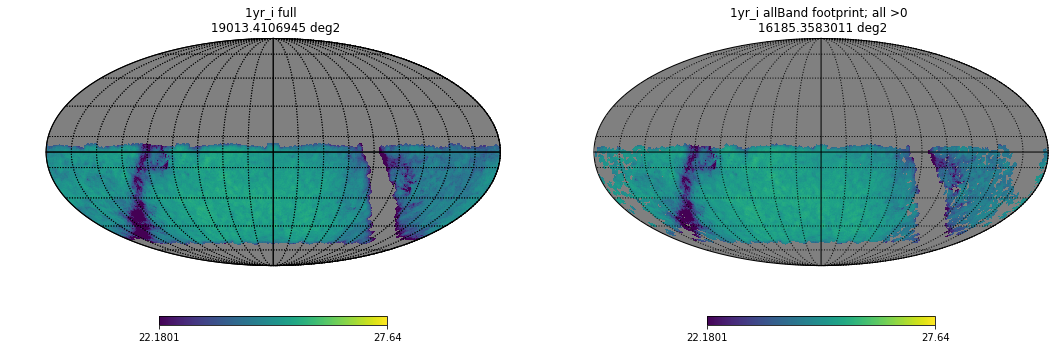

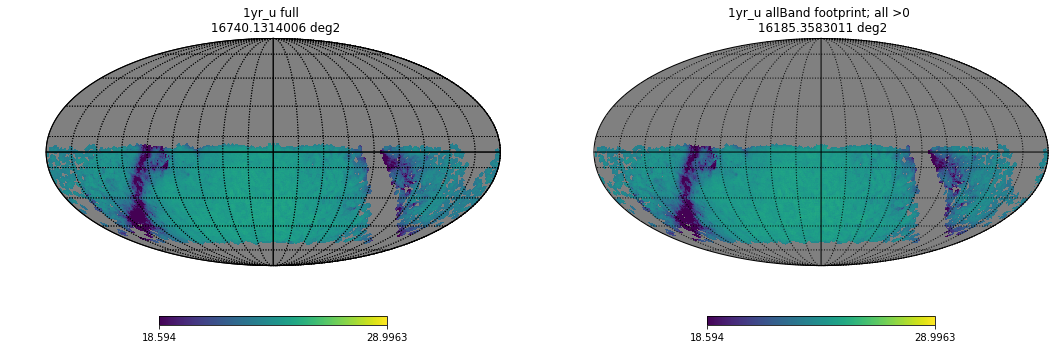

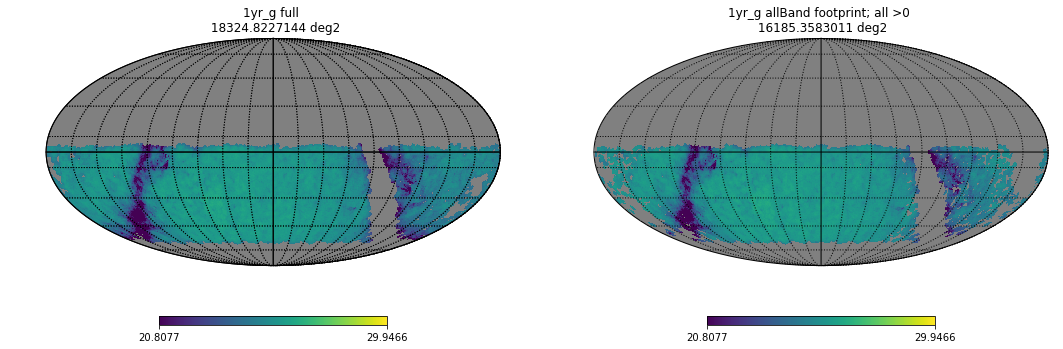

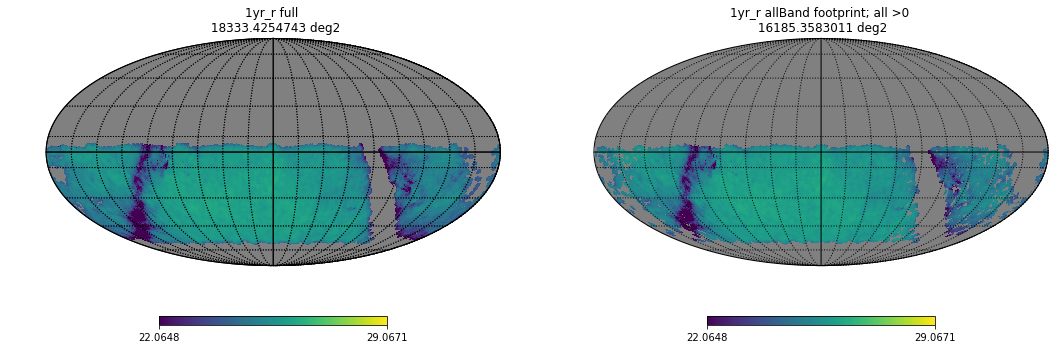

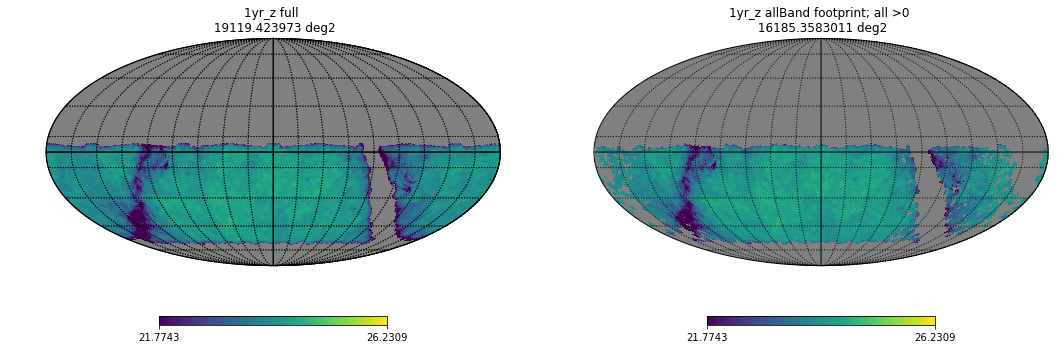

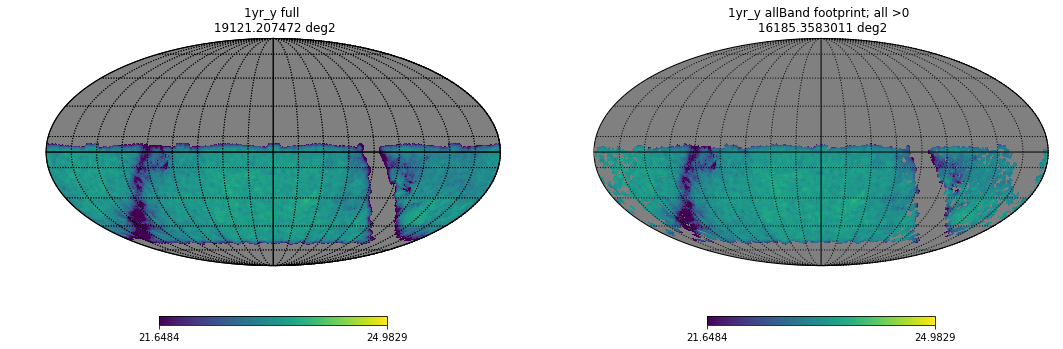

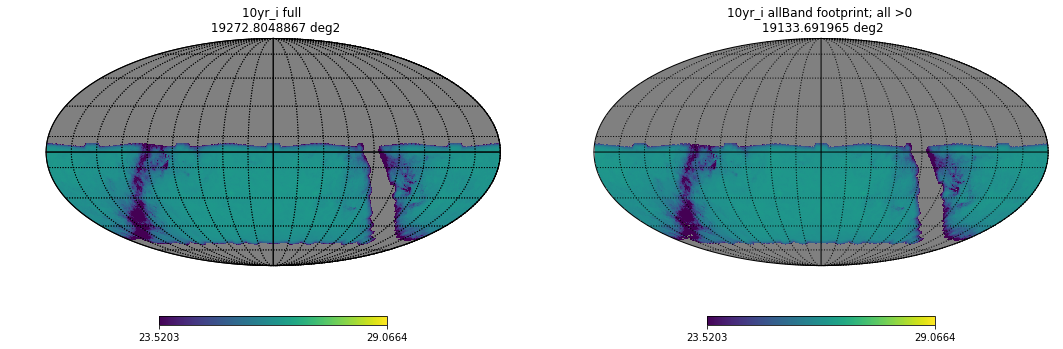

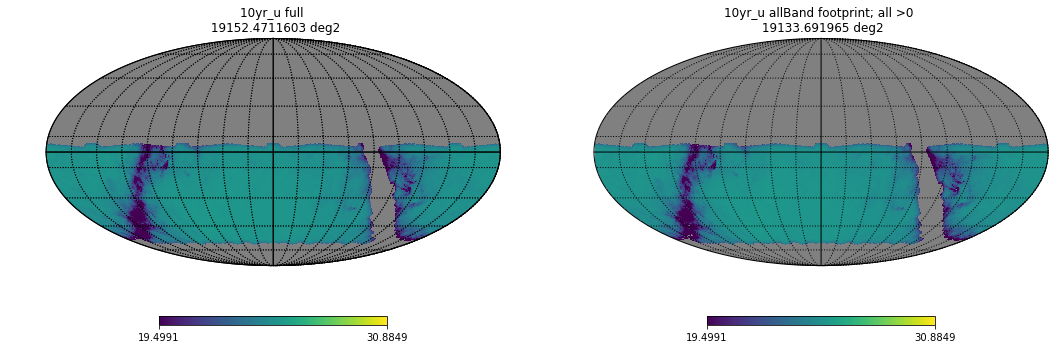

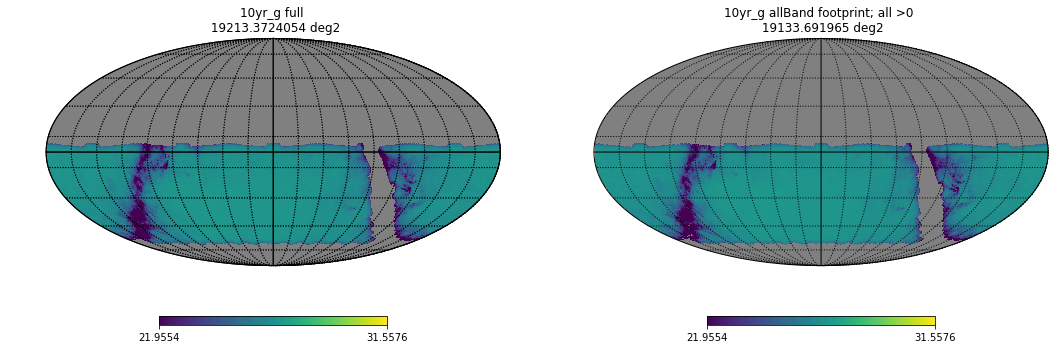

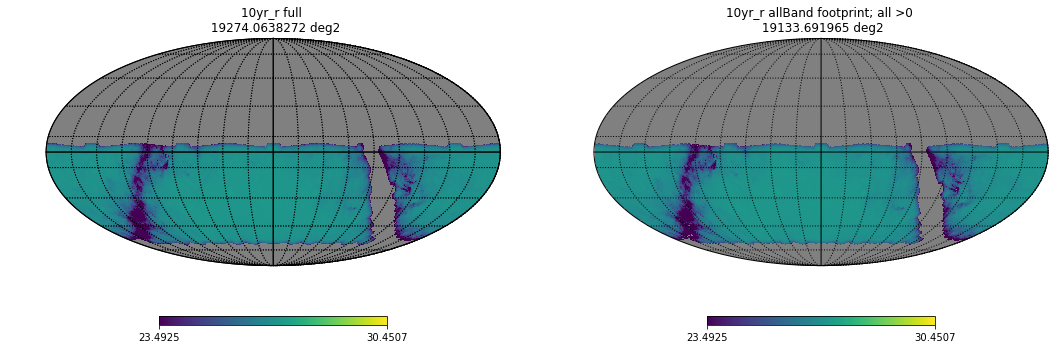

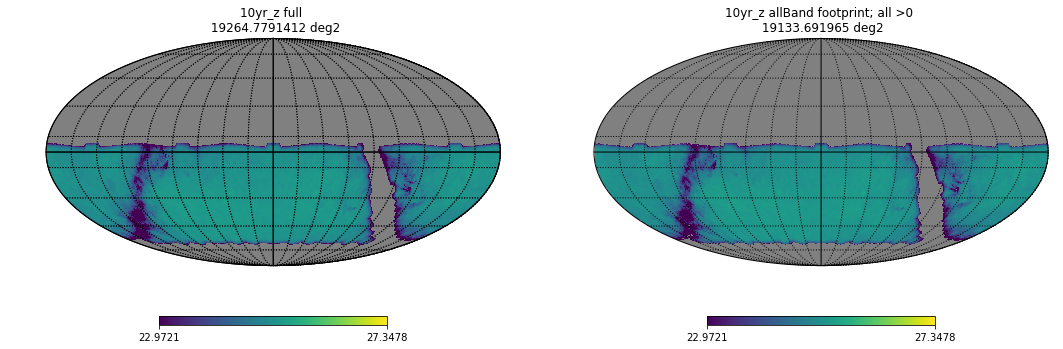

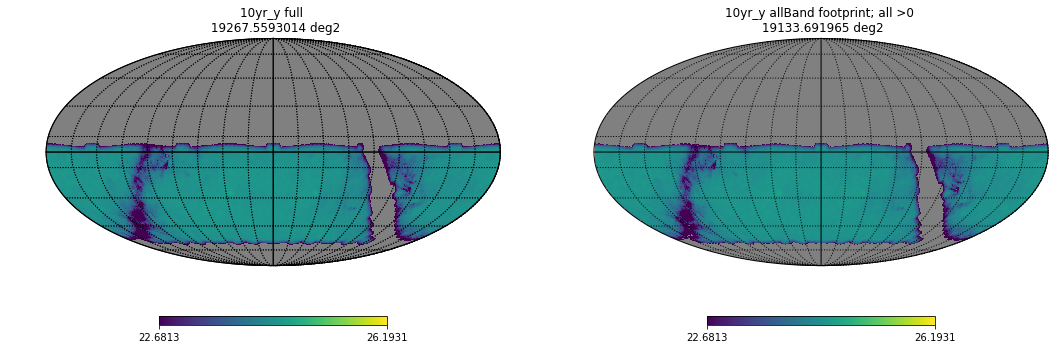

In [13]:
for band in dataMaps.keys():
    inSurveyIndex= np.where(dataMaps[band].mask == False)[0]
    median= np.median(dataMaps[band].data[inSurveyIndex])
    stddev= np.std(dataMaps[band].data[inSurveyIndex])
    colorMin= median-2.5*stddev
    colorMax= median+2.5*stddev
        
    plt.clf()
    fig, axes= plt.subplots(1,2)
    # full survey
    plt.axes(axes[0])
    hp.mollview(dataMaps[band], hold= True,
                min= colorMin, max= colorMax, 
                title= '%s full \n %s deg2'%(band, len(inSurveyIndex)*areaPerPixel),
                flip= 'astro', 
                rot=(0,0,0),cbar=True, )
    hp.graticule(dpar=20, dmer=20, verbose=False)

    # footprint that is common to all six bands
    yrTag= band.split('yr')[0]+'yr'
    
    plt.axes(axes[1])
    newMap= deepcopy(dataMaps[band])
    newMap.mask[:]= True
    newMap.mask[allBandData_Ind[yrTag]]= False

    hp.mollview(newMap, hold= True,
                min= colorMin, max= colorMax, 
                title= '%s allBand footprint; all >0 \n %s deg2'%(band, len(allBandData_Ind[yrTag])*areaPerPixel),
                flip= 'astro', 
                rot=(0,0,0),cbar=True, )
    hp.graticule(dpar=20, dmer=20, verbose=False)

    fig.set_size_inches(18, 18)
    plt.show()

#### For 1yr, u-band is the most restrictive. Also, ~550 deg2 covered in u-band doesnt overlap with the rest of the bands -- could be optimized if u-band cadence is to remain as the most restrictive.

This (^) problem isnt as important for 10yr case: u-band footprint is still the most restrictive but only ~20deg2 covered in u-band is not covered in the rest.

In [14]:
def stats(arr):
    # function to reutrn min, max, mean, median, std, inter-quartile range in the given array
    return [np.nanmin(arr), np.nanmax(arr) , np.nanmean(arr), np.nanmedian(arr), np.nanstd(arr), iqr(arr)]

Find the stats in 1yr, 10yr data for all six bands, both in the full band-specific footprint and all-band footprint.

In [15]:
allYrData= {}
for yrTag in ['1yr', '10yr']:
    allData= pd.DataFrame(OrderedDict(), index= ['min', 'max', 'mean', 'median', 'std', 'iqr', 'coverage'])
    for key in dataMaps:
        if key.__contains__(yrTag):
            # stats on the full inSurvey region
            inSurveyIndex= np.where(dataMaps[key].mask == False)[0]
            data= stats(dataMaps[key].data[inSurveyIndex])
            coverage= len(inSurveyIndex)*areaPerPixel
            data= np.hstack([data, coverage])
            # add to df
            kwargs = {key : data}
            allData= allData.assign(**kwargs)
            
            # common
            coverage= len(allBandData_Ind[yrTag])*areaPerPixel
            data= stats(dataMaps[key].data[allBandData_Ind[yrTag]])
            data= np.hstack([data, coverage])
            # add to df
            colName= "***%s all-Band footprint; all > 0"%(key)
            kwargs = {colName: data}
            allData= allData.assign(**kwargs)
                 
    display(allData)
    allYrData[yrTag]= allData

1yr_i  ***1yr_i all-Band footprint; all > 0         1yr_u  \
min        -152.821969                             14.087266   -372.342524   
max          25.773374                             25.773374     24.975136   
mean         24.654289                             24.766918     23.321441   
median       24.910058                             25.004494     23.795161   
std           1.091976                              0.780776      2.080454   
iqr           0.798986                              0.716107      1.187271   
coverage  19013.410694                          16185.358301  16740.131401   

          ***1yr_u all-Band footprint; all > 0         1yr_g  \
min                                   0.031264   -304.098713   
max                                  24.975136     26.502077   
mean                                 23.357797     24.939919   
median                               23.833998     25.377166   
std                                   1.644171      1.827769   
iqr                                   1.162030      0.966965   
coverage                          16185.358301  18324.822714   

          ***1yr_g all-Band footprint; all > 0         1yr_r  \
min                                   5.543241   -205.216609   
max                                  26.502077     26.513315   
mean                                 25.041909     25.216401   
median                               25.455150     25.565945   
std                                   1.333911      1.400463   
iqr                                   0.885678      1.008973   
coverage                          16185.358301  18333.425474   

          ***1yr_r all-Band footprint; all > 0         1yr_z  \
min                                  11.512547   -111.433549   
max                                  26.513315     24.821331   
mean                                 25.359362     23.793343   
median                               25.662881     24.002597   
std                                   0.984995      0.891319   
iqr                                   0.826361      0.501918   
coverage                          16185.358301  19119.423973   

          ***1yr_z all-Band footprint; all > 0         1yr_y  \
min                                  15.368754    -78.555655   
max                                  24.821331     23.886662   
mean                                 23.880487     23.146302   
median                               24.044798     23.315667   
std                                   0.619121      0.666890   
iqr                                   0.464225      0.348351   
coverage                          16185.358301  19121.207472   

          ***1yr_y all-Band footprint; all > 0  
min                                  16.191196  
max                                  23.886662  
mean                                 23.218989  
median                               23.343817  
std                                   0.440775  
iqr                                   0.306374  
coverage                          16185.358301

10yr_i  ***10yr_i all-Band footprint; all > 0        10yr_u  \
min        -151.772211                              14.286373   -370.554687   
max          26.679740                              26.679740     25.757250   
mean         25.958764                              25.990043     24.570175   
median       26.293357                              26.295178     25.192003   
std           1.109205                               0.839882      2.277151   
iqr           0.408970                               0.393926      0.735090   
coverage  19272.804887                           19133.691965  19152.471160   

          ***10yr_u all-Band footprint; all > 0        10yr_g  \
min                                    0.069105   -302.896167   
max                                   25.757250     27.235859   
mean                                  24.598613     26.220663   
median                                25.192493     26.756480   
std                                    1.715268      1.920448   
iqr                                    0.732120      0.629674   
coverage                           19133.691965  19213.372405   

          ***10yr_g all-Band footprint; all > 0        10yr_r  \
min                                    5.534278   -204.021438   
max                                   27.235859     27.382168   
mean                                  26.254562     26.563560   
median                                26.758179     26.971586   
std                                    1.438881      1.391644   
iqr                                    0.616227      0.489916   
coverage                           19133.691965  19274.063827   

          ***10yr_r all-Band footprint; all > 0        10yr_z  \
min                                   11.916446   -109.806659   
max                                   27.382168     25.530116   
mean                                  26.599477     24.910296   
median                                26.973751     25.159962   
std                                    1.044596      0.875150   
iqr                                    0.471217      0.331439   
coverage                           19133.691965  19264.779141   

          ***10yr_z all-Band footprint; all > 0        10yr_y  \
min                                   15.572702    -77.481776   
max                                   25.530116     24.773968   
mean                                  24.937027     24.213680   
median                                25.161463     24.437206   
std                                    0.667873      0.702356   
iqr                                    0.321945      0.247627   
coverage                           19133.691965  19267.559301   

          ***10yr_y all-Band footprint; all > 0  
min                                   17.053497  
max                                   24.773968  
mean                                  24.237804  
median                                24.438225  
std                                    0.540690  
iqr                                    0.237840  
coverage                           19133.691965

Plot i-band histograms to see whats happens to the area converage with depth.

Tot area in the counts: 16185.3583011 deg2


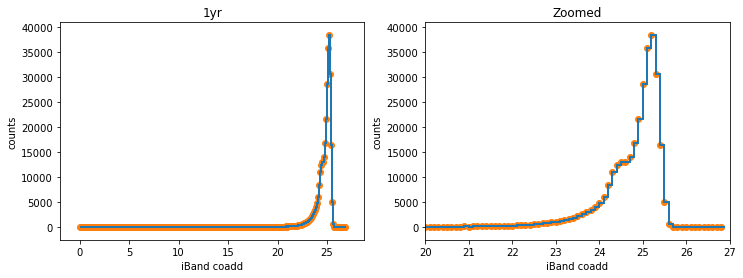

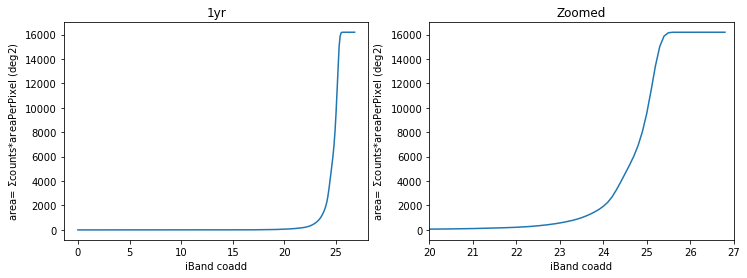

Tot area in the counts: 19133.691965 deg2


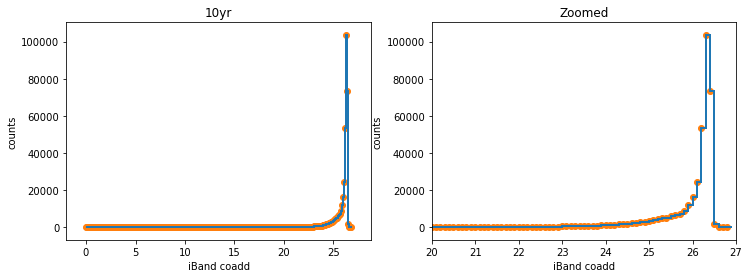

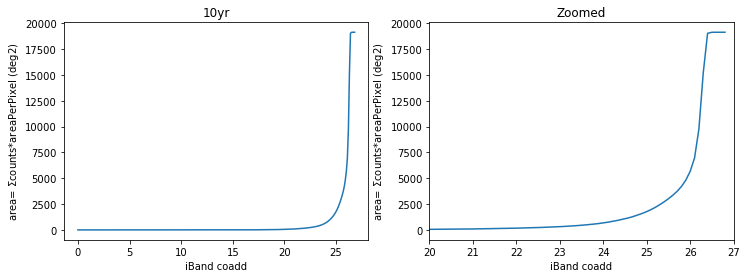

In [16]:
for yrTag in allYrData:
    # counts vs. coadd
    # focus on the 0-27 mag distribution.
    plt.clf()
    fig, axes= plt.subplots(1,2)
    ax=axes[0]
    counts, bins, eh= ax.hist(dataMaps[yrTag+'_i'].data[allBandData_Ind[yrTag]], 
                               bins= np.arange(0., 27, 0.1), histtype= 'step', lw= 2)
    ax.scatter(bins[0:-1], counts)
    ax.set_xlabel('iBand coadd')
    ax.set_ylabel('counts')
    ax.set_title(yrTag)
    print('Tot area in the counts: %s deg2'%sum(counts*areaPerPixel))

    ax=axes[1]
    countsZoomed, binsZoomed, eh= ax.hist(dataMaps[yrTag+'_i'].data[allBandData_Ind[yrTag]], 
                               bins= np.arange(0., 27, 0.1), histtype= 'step', lw= 2)
    ax.scatter(binsZoomed[0:-1], countsZoomed)
    ax.set_xlabel('iBand coadd')
    ax.set_ylabel('counts')
    ax.set_title('Zoomed')
    ax.set_xlim(20,27)
    fig.set_size_inches(12, 4)
    plt.show()
    
    # cumulative area vs. coadd
    plt.clf()
    fig, axes= plt.subplots(1,2)
    ax=axes[0]
    ax.plot(bins[0:-1], np.cumsum(counts*areaPerPixel))
    ax.set_xlabel('iBand coadd')
    ax.set_ylabel('area= $\Sigma$counts*areaPerPixel (deg2)')
    ax.set_title(yrTag)

    ax=axes[1]
    ax.plot(bins[0:-1], np.cumsum(counts*areaPerPixel))
    ax.set_xlabel('iBand coadd')
    ax.set_ylabel('area= $\Sigma$counts*areaPerPixel (deg2)')
    ax.set_title('Zoomed')
    ax.set_xlim(20,27)
    
    fig.set_size_inches(12, 4)
    plt.show()

Implement depth cuts in i-band and calculate stats in all bands in the depth-limit region in the all-band footprint.

In [17]:
iCutPixels= {}   # store the good pixel indices for plotting later.
lowCuts= {'1yr': [23., 24.0], '10yr': [24.5, 25.0],}

for yrTag in lowCuts:
    iCutPixels[yrTag]= {}
    # print out stats for all-band, no cut for reference.
    prevData= allYrData[yrTag]
    cols= [x for x in prevData.keys() if (x.__contains__('***') ) ]
    display(prevData[cols])
    
    # run over different cuts
    for lowCut in lowCuts[yrTag]:
        allData= pd.DataFrame(OrderedDict(), index= ['min', 'max', 'mean', 'median', 'std', 'iqr', 'coverage'])
        
        bandKeys= [yrTag+'_'+x for x in orderBand] # want to maintain i ugrzy order.
        iBandKey= [b for b in bandKeys if b.__contains__('i')][0]  # select out the i-band key
        
        # find the pixels satisfying the iBand cut.
        iBandCutInd= np.where((dataMaps[iBandKey].data[allBandData_Ind[yrTag]]>=lowCut))[0]
        iCutPixels[yrTag][lowCut]= np.array(allBandData_Ind[yrTag])[iBandCutInd] # store
        # calculate the stats
        data= stats(dataMaps[iBandKey].data[allBandData_Ind[yrTag]][iBandCutInd])
        coverage= len(iBandCutInd)*areaPerPixel
        data= np.hstack([data, coverage])
        # add to df
        colName= "**%s_i : i>%s in allBand footprint"%(yrTag, lowCut)
        kwargs = {colName: data}
        allData= allData.assign(**kwargs)
        
        # run over the rest of the bands
        otherBands= bandKeys[1::]
        for band in otherBands:
            data= stats(dataMaps[band].data[allBandData_Ind[yrTag]][iBandCutInd])
            coverage= len(iBandCutInd)*areaPerPixel
            data= np.hstack([data, coverage])
            # add to df
            colName= "**%s : i>%s in allBand footprint"%(band, lowCut)
            kwargs = {colName: data}
            allData= allData.assign(**kwargs)

        display(allData) #[cols])
        
        # add to the df? 
        # need to check the columns dont exist (problematic if re-run only the current cell without initiating the df)
        prev= allYrData[yrTag]
        alreadyExists= False
        for colKey in allData.keys(): 
            if colKey in prev.keys(): alreadyExists= True
        if alreadyExists: print('Not adding data for %s: i>%s; column already exists?'%(yrTag, lowCut))
        else:
            allYrData[yrTag]= prev.join(allData)
    print('-------------- -------------- -------------- -------------- -------------- --------------' )
    print('-------------- -------------- -------------- -------------- -------------- --------------' )

***1yr_i all-Band footprint; all > 0  \
min                                  14.087266   
max                                  25.773374   
mean                                 24.766918   
median                               25.004494   
std                                   0.780776   
iqr                                   0.716107   
coverage                          16185.358301   

          ***1yr_u all-Band footprint; all > 0  \
min                                   0.031264   
max                                  24.975136   
mean                                 23.357797   
median                               23.833998   
std                                   1.644171   
iqr                                   1.162030   
coverage                          16185.358301   

          ***1yr_g all-Band footprint; all > 0  \
min                                   5.543241   
max                                  26.502077   
mean                                 25.041909   
median                               25.455150   
std                                   1.333911   
iqr                                   0.885678   
coverage                          16185.358301   

          ***1yr_r all-Band footprint; all > 0  \
min                                  11.512547   
max                                  26.513315   
mean                                 25.359362   
median                               25.662881   
std                                   0.984995   
iqr                                   0.826361   
coverage                          16185.358301   

          ***1yr_z all-Band footprint; all > 0  \
min                                  15.368754   
max                                  24.821331   
mean                                 23.880487   
median                               24.044798   
std                                   0.619121   
iqr                                   0.464225   
coverage                          16185.358301   

          ***1yr_y all-Band footprint; all > 0  
min                                  16.191196  
max                                  23.886662  
mean                                 23.218989  
median                               23.343817  
std                                   0.440775  
iqr                                   0.306374  
coverage                          16185.358301

**1yr_i : i>23.0 in allBand footprint  \
min                                   23.000023   
max                                   25.773374   
mean                                  24.864532   
median                                25.023065   
std                                    0.510943   
iqr                                    0.666175   
coverage                           15676.064426   

          **1yr_u : i>23.0 in allBand footprint  \
min                                   18.183852   
max                                   24.975136   
mean                                  23.571810   
median                                23.869785   
std                                    0.984957   
iqr                                    1.098994   
coverage                           15676.064426   

          **1yr_g : i>23.0 in allBand footprint  \
min                                   20.198982   
max                                   26.502077   
mean                                  25.215459   
median                                25.476826   
std                                    0.802822   
iqr                                    0.805809   
coverage                           15676.064426   

          **1yr_r : i>23.0 in allBand footprint  \
min                                   21.969515   
max                                   26.513315   
mean                                  25.483378   
median                                25.684222   
std                                    0.630554   
iqr                                    0.760163   
coverage                           15676.064426   

          **1yr_z : i>23.0 in allBand footprint  \
min                                   21.132240   
max                                   24.821331   
mean                                  23.957898   
median                                24.057666   
std                                    0.401050   
iqr                                    0.431788   
coverage                           15676.064426   

          **1yr_y : i>23.0 in allBand footprint  
min                                   21.023576  
max                                   23.886662  
mean                                  23.274703  
median                                23.352100  
std                                    0.280600  
iqr                                    0.283401  
coverage                           15676.064426

**1yr_i : i>24.0 in allBand footprint  \
min                                   24.000000   
max                                   25.773374   
mean                                  24.964684   
median                                25.062439   
std                                    0.375633   
iqr                                    0.552500   
coverage                           14510.128185   

          **1yr_u : i>24.0 in allBand footprint  \
min                                   20.474585   
max                                   24.975136   
mean                                  23.763405   
median                                23.943860   
std                                    0.684966   
iqr                                    0.933774   
coverage                           14510.128185   

          **1yr_g : i>24.0 in allBand footprint  \
min                                   21.130530   
max                                   26.502077   
mean                                  25.376296   
median                                25.524007   
std                                    0.546545   
iqr                                    0.655283   
coverage                           14510.128185   

          **1yr_r : i>24.0 in allBand footprint  \
min                                   23.365410   
max                                   26.513315   
mean                                  25.598738   
median                                25.728770   
std                                    0.476279   
iqr                                    0.634730   
coverage                           14510.128185   

          **1yr_z : i>24.0 in allBand footprint  \
min                                   21.804225   
max                                   24.821331   
mean                                  24.031646   
median                                24.086811   
std                                    0.299472   
iqr                                    0.372916   
coverage                           14510.128185   

          **1yr_y : i>24.0 in allBand footprint  
min                                   21.344891  
max                                   23.886662  
mean                                  23.324930  
median                                23.369034  
std                                    0.206846  
iqr                                    0.240785  
coverage                           14510.128185

-------------- -------------- -------------- -------------- -------------- --------------
-------------- -------------- -------------- -------------- -------------- --------------


***10yr_i all-Band footprint; all > 0  \
min                                   14.286373   
max                                   26.679740   
mean                                  25.990043   
median                                26.295178   
std                                    0.839882   
iqr                                    0.393926   
coverage                           19133.691965   

          ***10yr_u all-Band footprint; all > 0  \
min                                    0.069105   
max                                   25.757250   
mean                                  24.598613   
median                                25.192493   
std                                    1.715268   
iqr                                    0.732120   
coverage                           19133.691965   

          ***10yr_g all-Band footprint; all > 0  \
min                                    5.534278   
max                                   27.235859   
mean                                  26.254562   
median                                26.758179   
std                                    1.438881   
iqr                                    0.616227   
coverage                           19133.691965   

          ***10yr_r all-Band footprint; all > 0  \
min                                   11.916446   
max                                   27.382168   
mean                                  26.599477   
median                                26.973751   
std                                    1.044596   
iqr                                    0.471217   
coverage                           19133.691965   

          ***10yr_z all-Band footprint; all > 0  \
min                                   15.572702   
max                                   25.530116   
mean                                  24.937027   
median                                25.161463   
std                                    0.667873   
iqr                                    0.321945   
coverage                           19133.691965   

          ***10yr_y all-Band footprint; all > 0  
min                                   17.053497  
max                                   24.773968  
mean                                  24.237804  
median                                24.438225  
std                                    0.540690  
iqr                                    0.237840  
coverage                           19133.691965

**10yr_i : i>24.5 in allBand footprint  \
min                                    24.500011   
max                                    26.679740   
mean                                   26.143180   
median                                 26.307230   
std                                     0.404727   
iqr                                     0.306718   
coverage                            18146.735094   

          **10yr_u : i>24.5 in allBand footprint  \
min                                    20.848061   
max                                    25.757250   
mean                                   24.906711   
median                                 25.216517   
std                                     0.787965   
iqr                                     0.575427   
coverage                            18146.735094   

          **10yr_g : i>24.5 in allBand footprint  \
min                                    23.201681   
max                                    27.235859   
mean                                   26.514320   
median                                 26.778018   
std                                     0.660104   
iqr                                     0.478499   
coverage                            18146.735094   

          **10yr_r : i>24.5 in allBand footprint  \
min                                    24.486632   
max                                    27.382168   
mean                                   26.789093   
median                                 26.988394   
std                                     0.493296   
iqr                                     0.364560   
coverage                            18146.735094   

          **10yr_z : i>24.5 in allBand footprint  \
min                                    22.374362   
max                                    25.530116   
mean                                   25.057350   
median                                 25.172996   
std                                     0.342441   
iqr                                     0.264553   
coverage                            18146.735094   

          **10yr_y : i>24.5 in allBand footprint  
min                                    21.973466  
max                                    24.773968  
mean                                   24.334075  
median                                 24.445412  
std                                     0.289526  
iqr                                     0.182570  
coverage                            18146.735094

**10yr_i : i>25.0 in allBand footprint  \
min                                    25.000027   
max                                    26.679740   
mean                                   26.191129   
median                                 26.314372   
std                                     0.317683   
iqr                                     0.263774   
coverage                            17532.319690   

          **10yr_u : i>25.0 in allBand footprint  \
min                                    21.923507   
max                                    25.757250   
mean                                   24.996123   
median                                 25.230735   
std                                     0.622700   
iqr                                     0.501633   
coverage                            17532.319690   

          **10yr_g : i>25.0 in allBand footprint  \
min                                    24.128186   
max                                    27.235859   
mean                                   26.590525   
median                                 26.789454   
std                                     0.519288   
iqr                                     0.415848   
coverage                            17532.319690   

          **10yr_r : i>25.0 in allBand footprint  \
min                                    25.113518   
max                                    27.382168   
mean                                   26.846898   
median                                 26.996794   
std                                     0.388316   
iqr                                     0.316292   
coverage                            17532.319690   

          **10yr_z : i>25.0 in allBand footprint  \
min                                    23.310683   
max                                    25.530116   
mean                                   25.097097   
median                                 25.180014   
std                                     0.269300   
iqr                                     0.238565   
coverage                            17532.319690   

          **10yr_y : i>25.0 in allBand footprint  
min                                    22.703311  
max                                    24.773968  
mean                                   24.367590  
median                                 24.449617  
std                                     0.223646  
iqr                                     0.158399  
coverage                            17532.319690

-------------- -------------- -------------- -------------- -------------- --------------
-------------- -------------- -------------- -------------- -------------- --------------


#### Want to reduce std, iqr with depth cuts.

Plot the skymaps without mag cuts vs. with cuts.

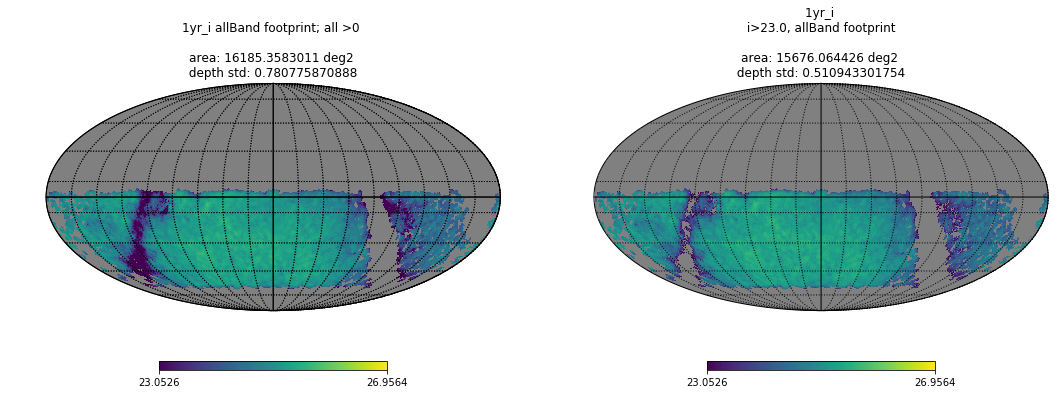

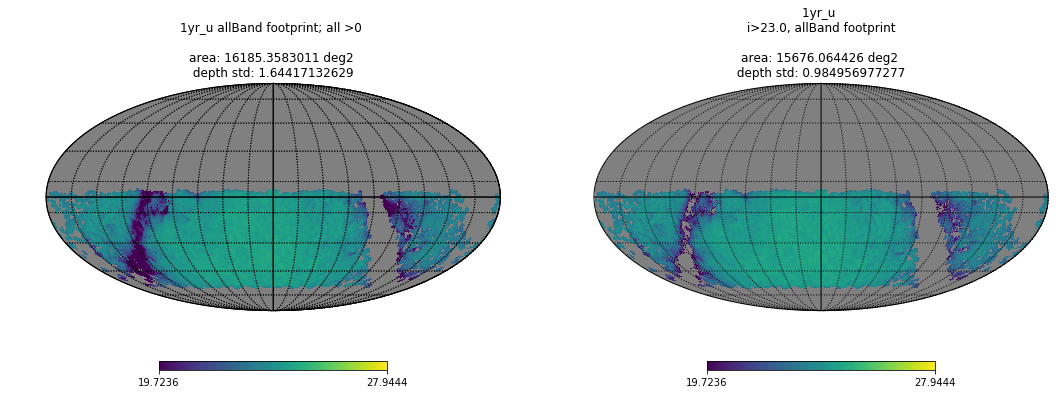

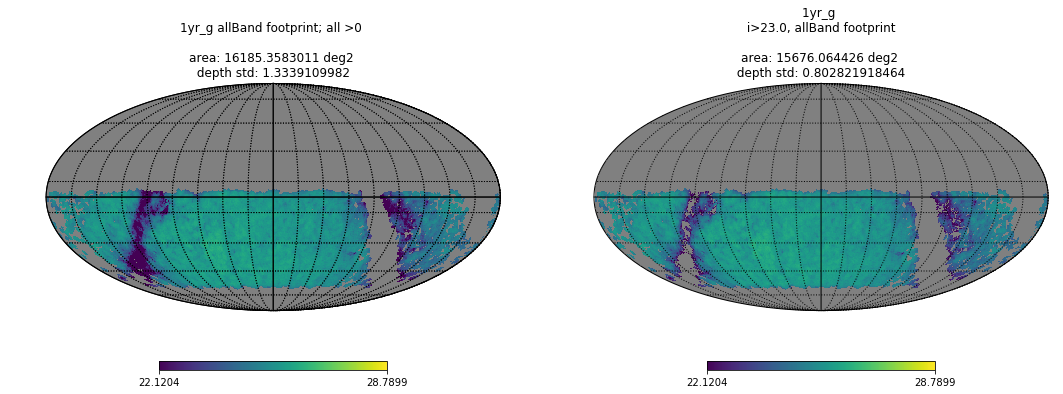

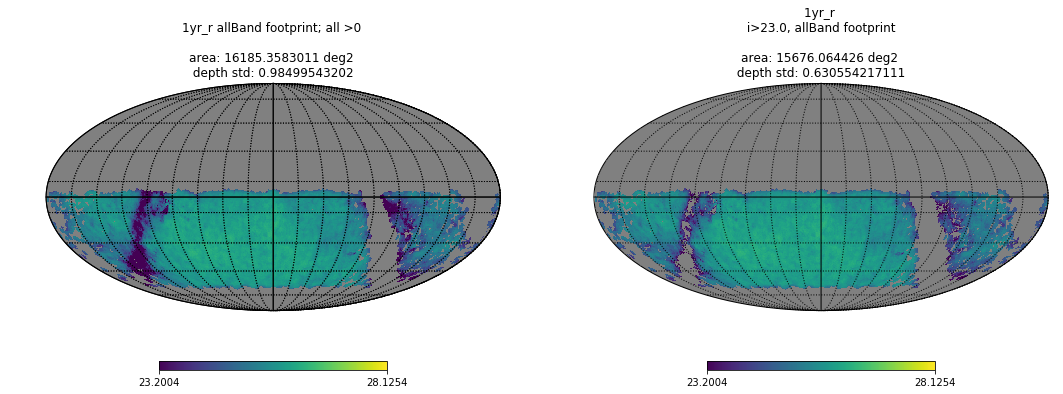

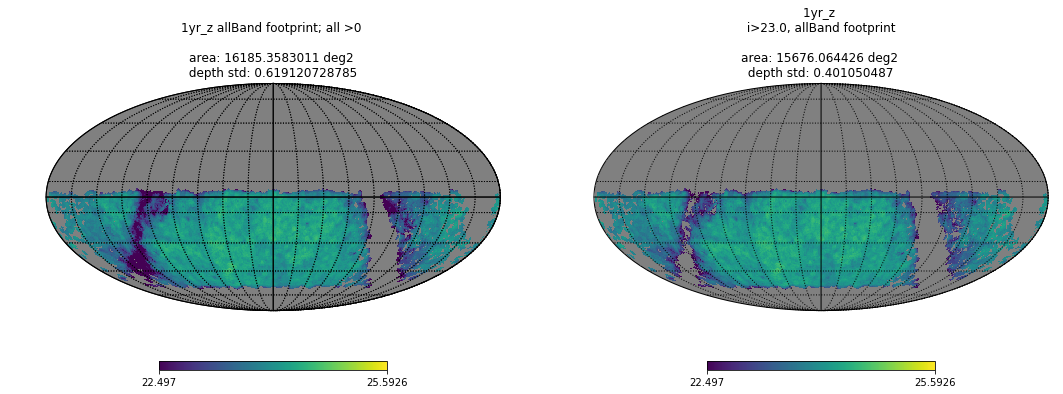

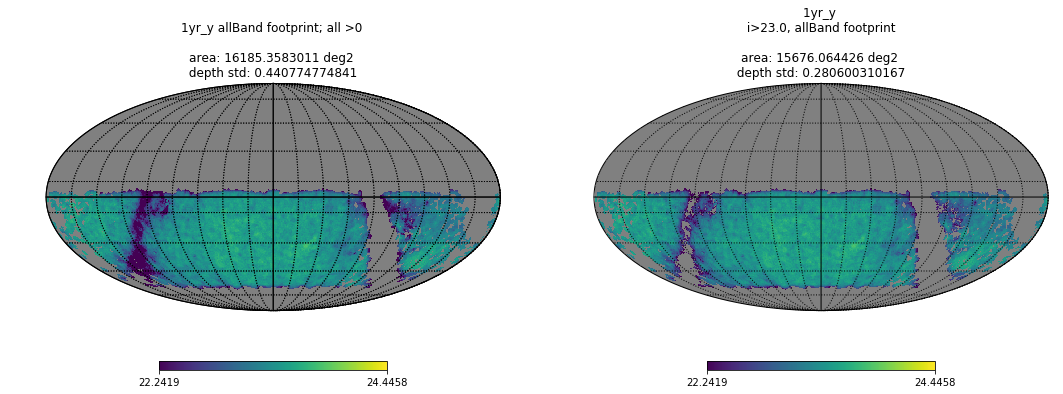

******************* ******************* ******************* ******************* *******************


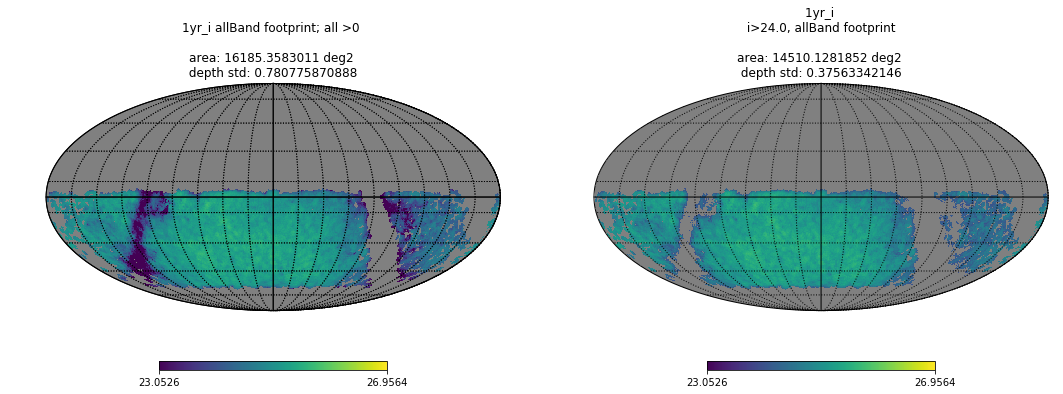

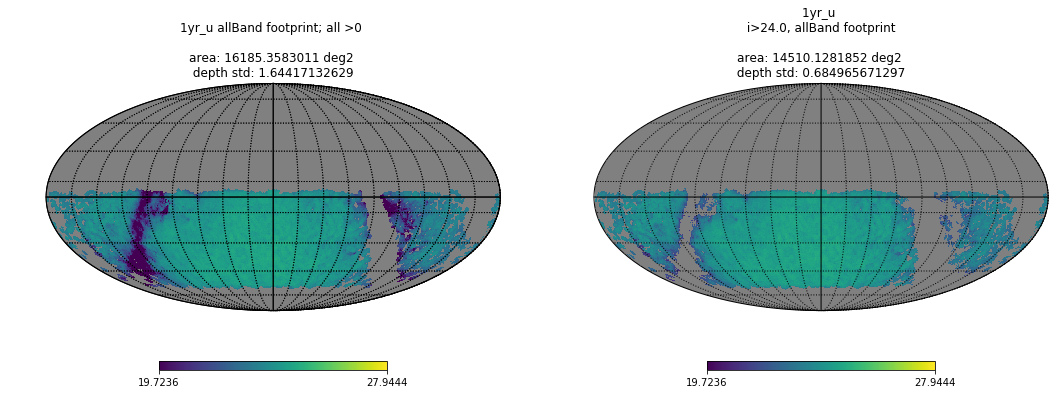

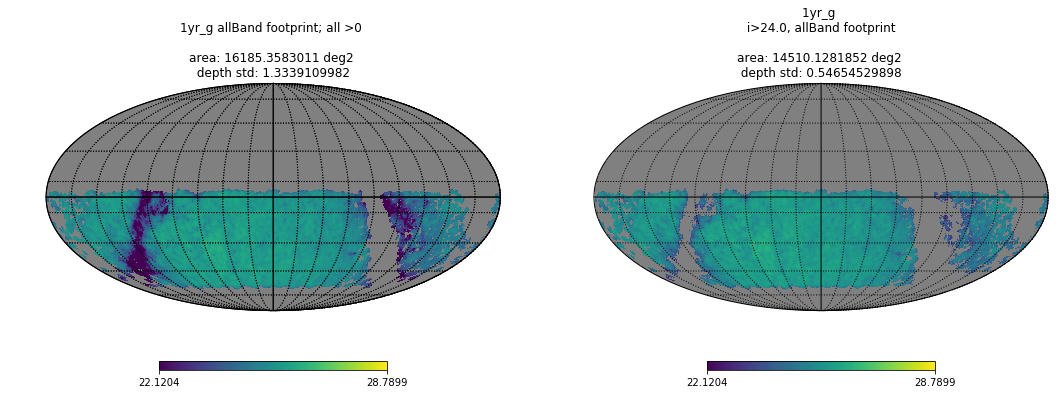

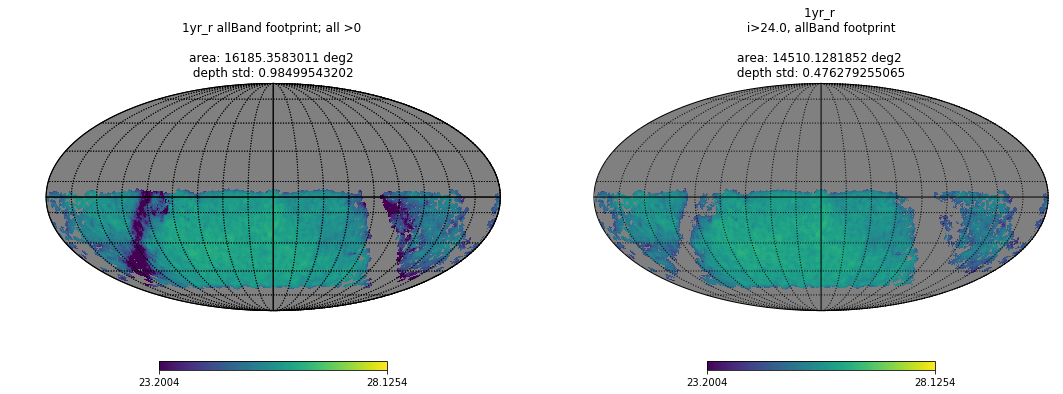

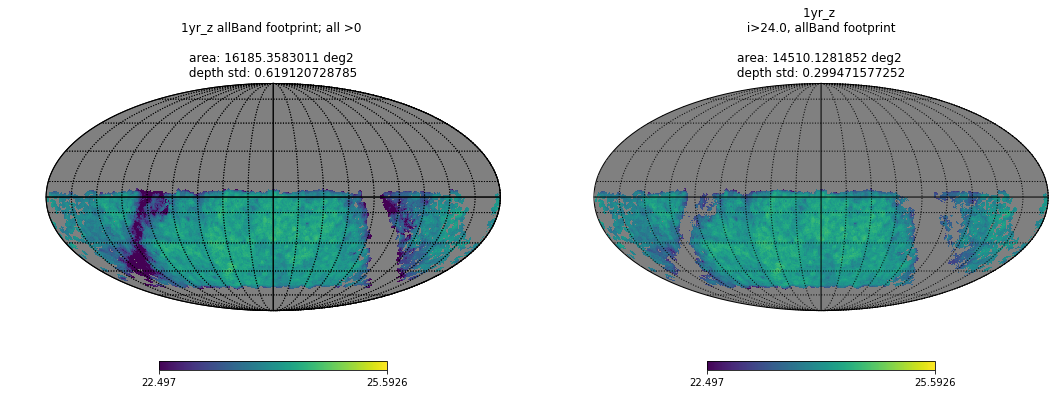

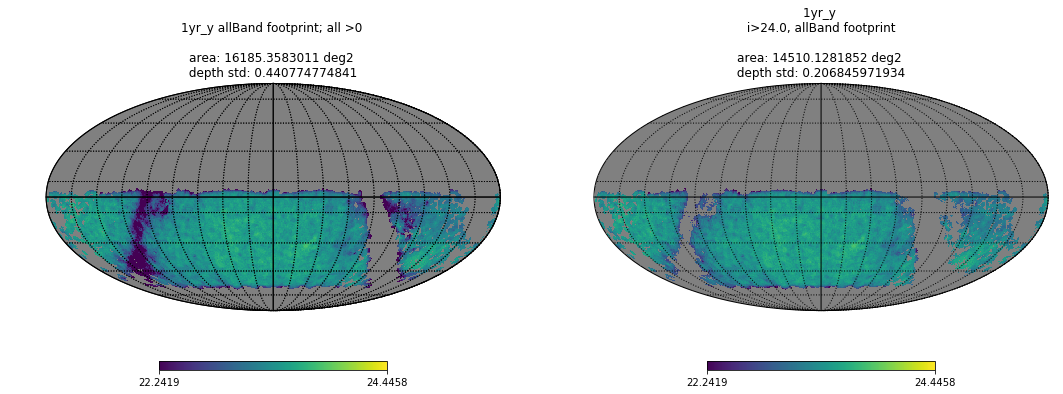

******************* ******************* ******************* ******************* *******************
-------------- -------------- -------------- -------------- -------------- --------------


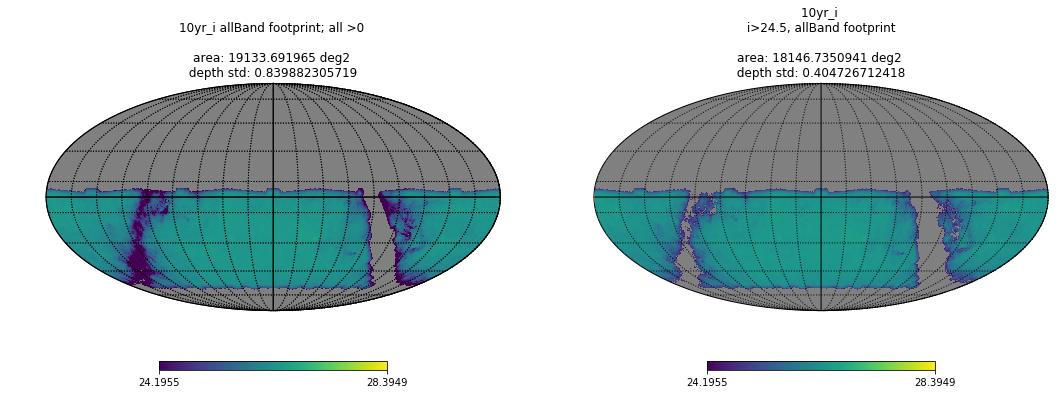

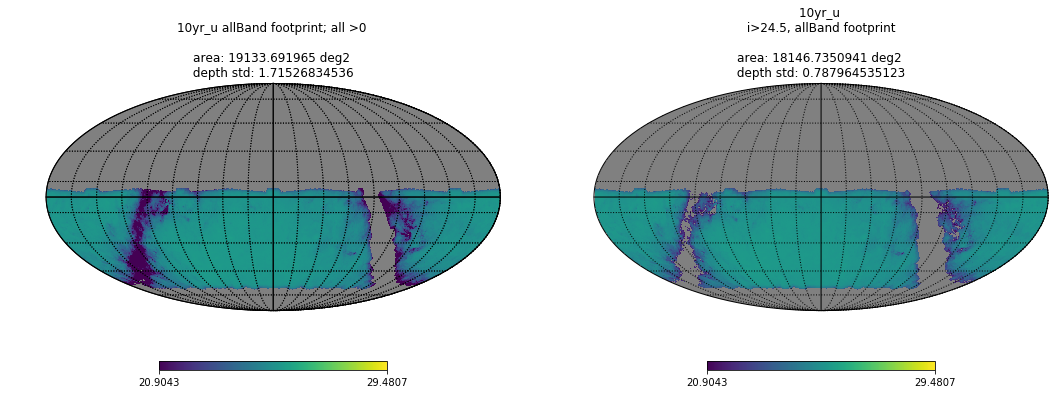

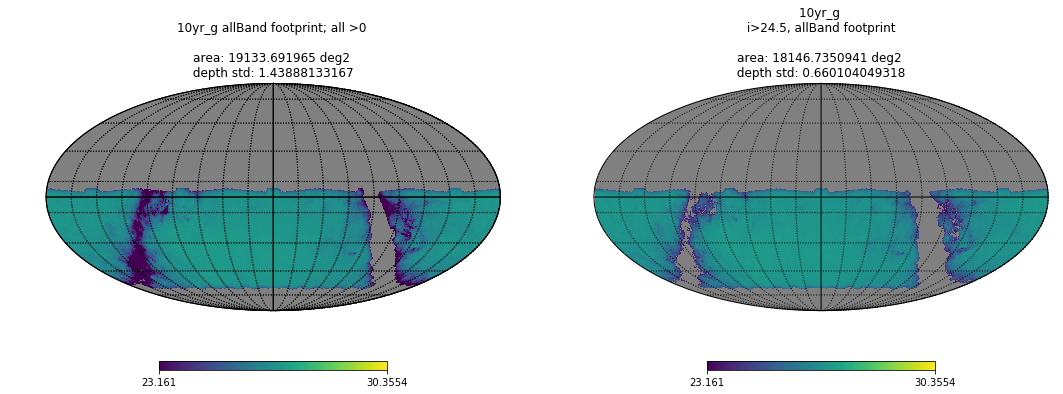

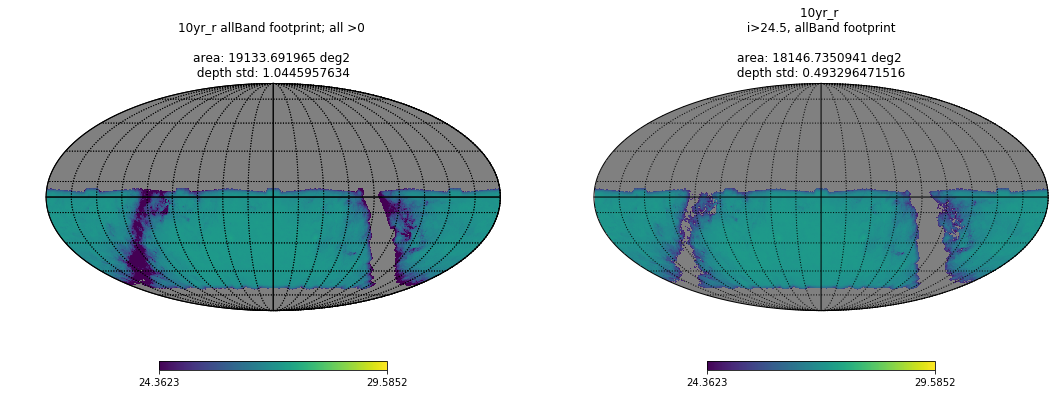

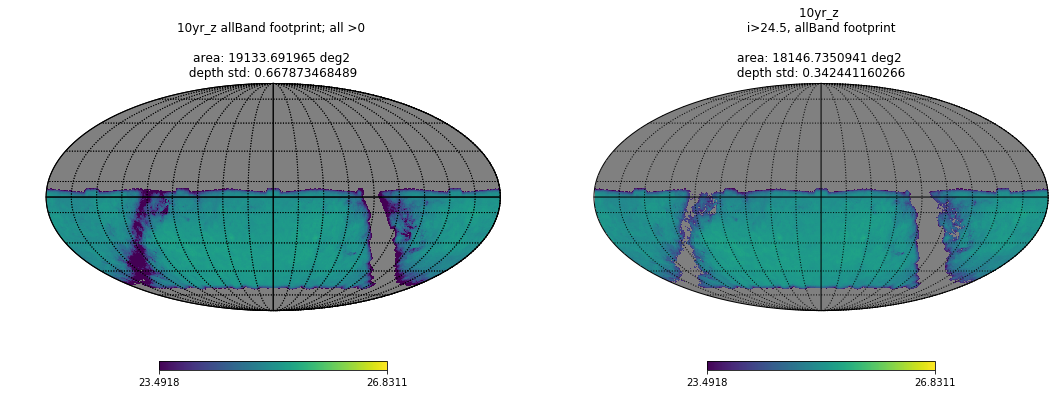

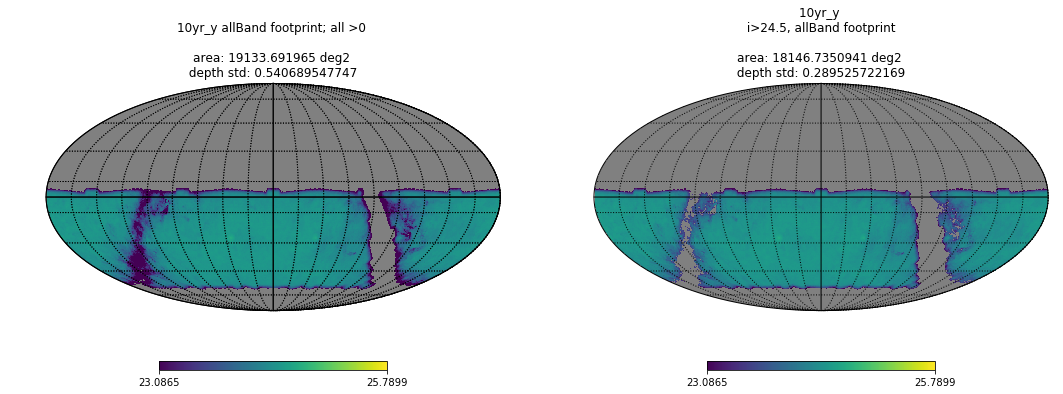

******************* ******************* ******************* ******************* *******************


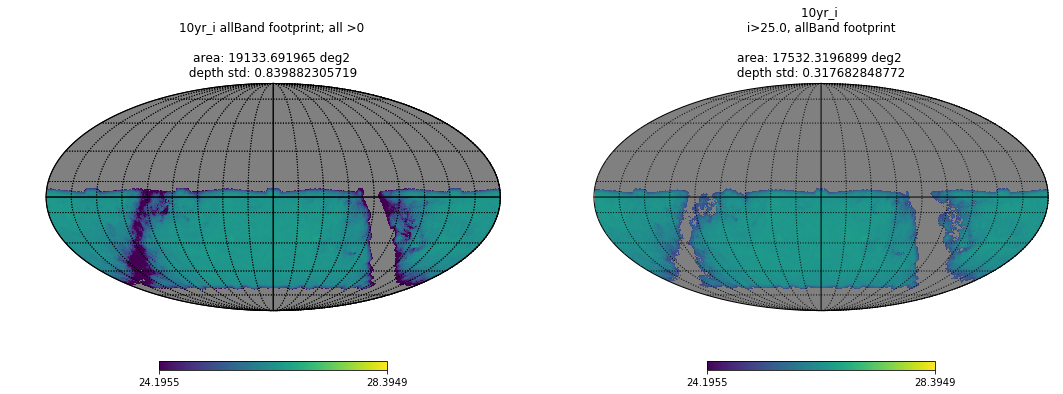

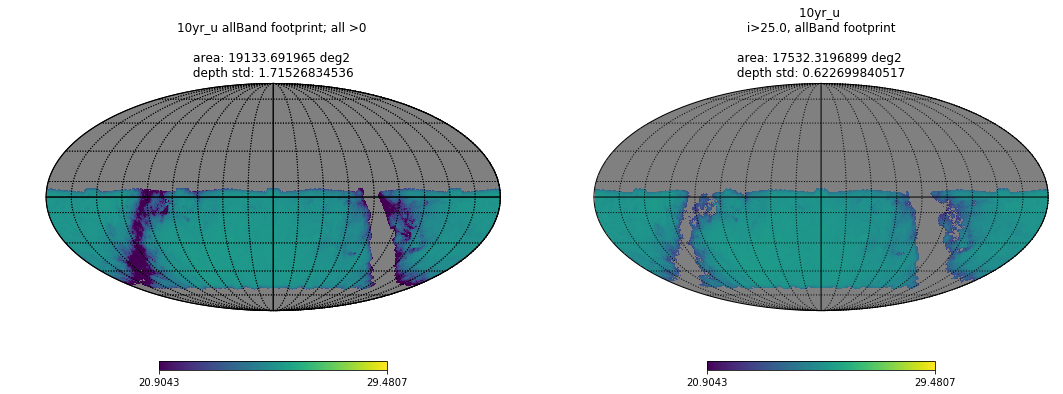

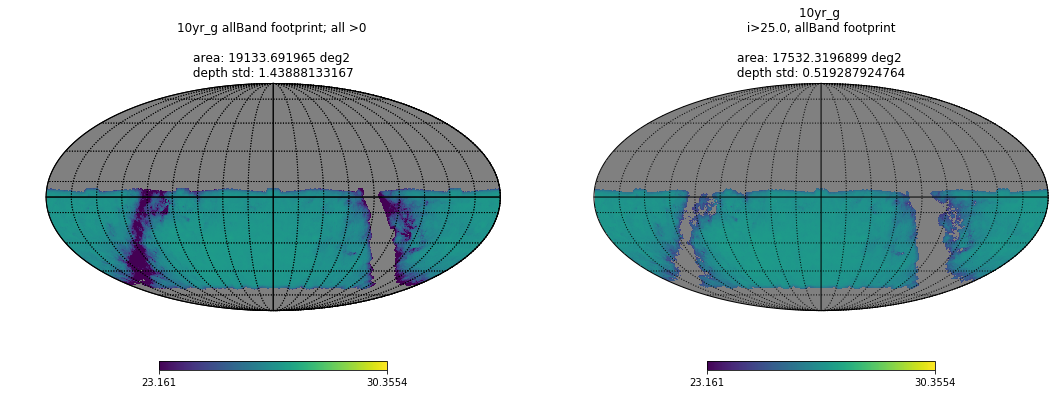

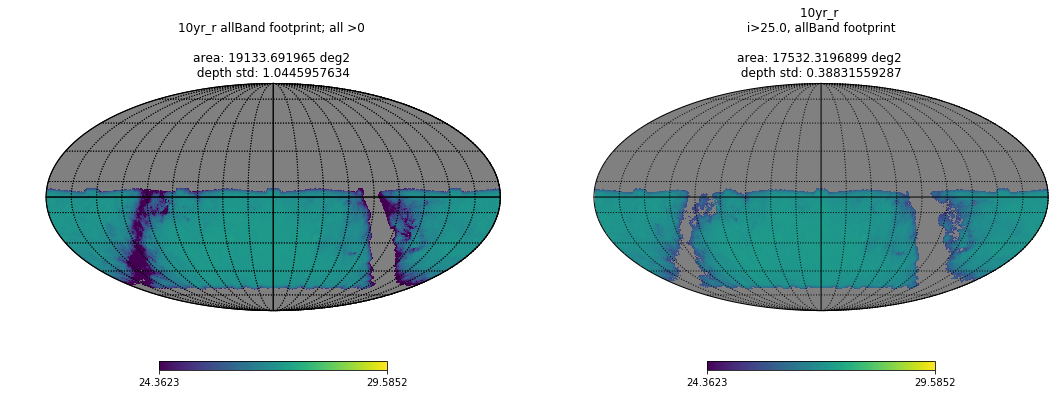

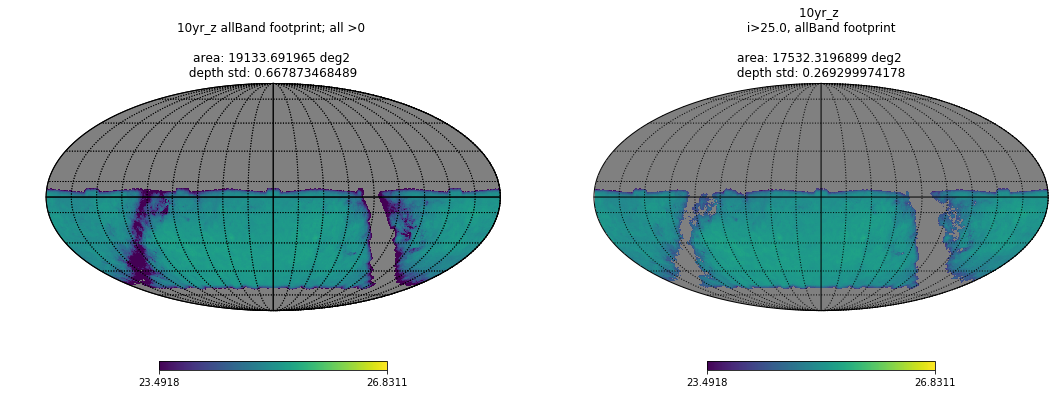

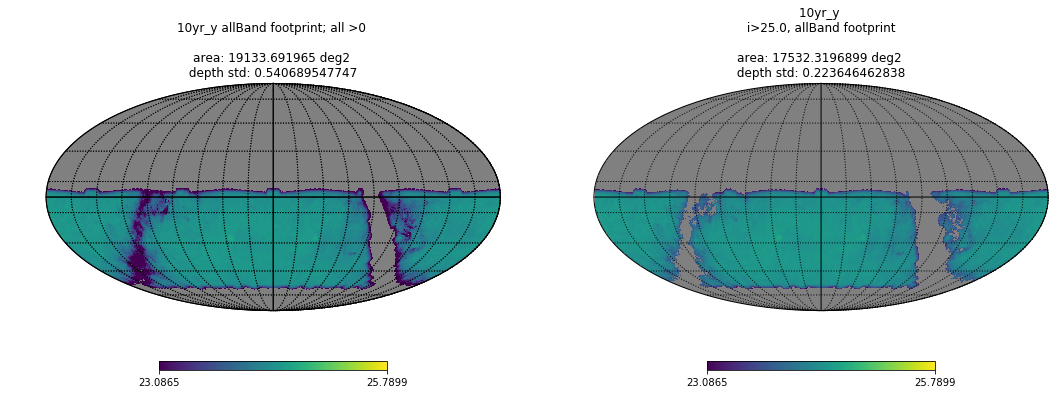

******************* ******************* ******************* ******************* *******************
-------------- -------------- -------------- -------------- -------------- --------------


In [18]:
for yrTag in lowCuts:    
    for lowCut in lowCuts[yrTag]: 
        bandKeys= [yrTag+'_'+x for x in orderBand]
        for band in bandKeys:
            plt.clf()
            fig, axes= plt.subplots(1,2)
            # all-band footprint survey
            newMap= deepcopy(dataMaps[band])
            newMap.mask[:]= True
            newMap.mask[allBandData_Ind[yrTag]]= False
            
            median= np.median(newMap.data[allBandData_Ind[yrTag]])
            stddev= np.std(newMap.data[allBandData_Ind[yrTag]])

            colorMin= median-2.5*stddev
            colorMax= median+2.5*stddev
            
            plt.axes(axes[0])
            title= '%s allBand footprint; all >0 \n\n'%band
            title+= 'area: %s deg2 \n depth std: %s '%(len(allBandData_Ind[yrTag])*areaPerPixel, stddev)
            hp.mollview(newMap, hold= True,
                        min= colorMin, max= colorMax, 
                        title= title,
                        flip= 'astro', 
                        rot=(0,0,0),cbar=True, )
            hp.graticule(dpar=20, dmer=20, verbose=False)

            # iCut-restricted region
            plt.axes(axes[1])
            newMap= deepcopy(dataMaps[band])
            newMap.mask[:]= True
            newMap.mask[iCutPixels[yrTag][lowCut]]= False   # where iband cut is applied

            stddev= np.std(newMap.data[iCutPixels[yrTag][lowCut]])
            
            title= '%s \n i>%s, allBand footprint \n\n'%(band, lowCut)
            title+= 'area: %s deg2 \n depth std: %s '%(len(iCutPixels[yrTag][lowCut])*areaPerPixel, stddev)
            
            hp.mollview(newMap, hold= True,
                        min= colorMin, max= colorMax, 
                        title= title,
                        flip= 'astro', 
                        rot=(0,0,0),cbar=True, )
            hp.graticule(dpar=20, dmer=20, verbose=False)

            fig.set_size_inches(18, 18)
            plt.show()
        print('******************* ******************* ******************* ******************* *******************')
    print('-------------- -------------- -------------- -------------- -------------- --------------')

#### Finalized cuts.

In [19]:
# print out the final columns with only some rows again; as in Out 17.
yr= '1yr'
cols= [x for x in allYrData[yr].keys() if x.__contains__('i>24.0')]
display(allYrData[yr][cols])

# print out the final columns again; as in Out 17.
yr= '10yr'
cols= [x for x in allYrData[yr].keys() if x.__contains__('i>25.0')]
display(allYrData[yr][cols])

**1yr_i : i>24.0 in allBand footprint  \
min                                   24.000000   
max                                   25.773374   
mean                                  24.964684   
median                                25.062439   
std                                    0.375633   
iqr                                    0.552500   
coverage                           14510.128185   

          **1yr_u : i>24.0 in allBand footprint  \
min                                   20.474585   
max                                   24.975136   
mean                                  23.763405   
median                                23.943860   
std                                    0.684966   
iqr                                    0.933774   
coverage                           14510.128185   

          **1yr_g : i>24.0 in allBand footprint  \
min                                   21.130530   
max                                   26.502077   
mean                                  25.376296   
median                                25.524007   
std                                    0.546545   
iqr                                    0.655283   
coverage                           14510.128185   

          **1yr_r : i>24.0 in allBand footprint  \
min                                   23.365410   
max                                   26.513315   
mean                                  25.598738   
median                                25.728770   
std                                    0.476279   
iqr                                    0.634730   
coverage                           14510.128185   

          **1yr_z : i>24.0 in allBand footprint  \
min                                   21.804225   
max                                   24.821331   
mean                                  24.031646   
median                                24.086811   
std                                    0.299472   
iqr                                    0.372916   
coverage                           14510.128185   

          **1yr_y : i>24.0 in allBand footprint  
min                                   21.344891  
max                                   23.886662  
mean                                  23.324930  
median                                23.369034  
std                                    0.206846  
iqr                                    0.240785  
coverage                           14510.128185

**10yr_i : i>25.0 in allBand footprint  \
min                                    25.000027   
max                                    26.679740   
mean                                   26.191129   
median                                 26.314372   
std                                     0.317683   
iqr                                     0.263774   
coverage                            17532.319690   

          **10yr_u : i>25.0 in allBand footprint  \
min                                    21.923507   
max                                    25.757250   
mean                                   24.996123   
median                                 25.230735   
std                                     0.622700   
iqr                                     0.501633   
coverage                            17532.319690   

          **10yr_g : i>25.0 in allBand footprint  \
min                                    24.128186   
max                                    27.235859   
mean                                   26.590525   
median                                 26.789454   
std                                     0.519288   
iqr                                     0.415848   
coverage                            17532.319690   

          **10yr_r : i>25.0 in allBand footprint  \
min                                    25.113518   
max                                    27.382168   
mean                                   26.846898   
median                                 26.996794   
std                                     0.388316   
iqr                                     0.316292   
coverage                            17532.319690   

          **10yr_z : i>25.0 in allBand footprint  \
min                                    23.310683   
max                                    25.530116   
mean                                   25.097097   
median                                 25.180014   
std                                     0.269300   
iqr                                     0.238565   
coverage                            17532.319690   

          **10yr_y : i>25.0 in allBand footprint  
min                                    22.703311  
max                                    24.773968  
mean                                   24.367590  
median                                 24.449617  
std                                     0.223646  
iqr                                     0.158399  
coverage                            17532.319690